# fg Protocol ( Sim by Sim )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from jinja2 import Environment, FileSystemLoader, StrictUndefined

from tqdm import tqdm
import subprocess
import os
import sys
sys.path.append('../../../../src')

from utils import parse_openfoam_case

In [ ]:
# u = 0.5                   # cm3/min
u = 2.0                     # cm3/min
A = (3.81 / 2)**2 * np.pi   # cm2

ut = (u / A) / 60 / 100     # cm/min to m/s
ut

2.9237410983555335e-05

In [22]:
fgs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# Dont make sense waiting steady-state with no gas injection (fg = 0.0)

values_ua = np.array([ ut * fgx for fgx in fgs ])

# values_ua = values_ua[::-1]
values_ub = ut - values_ua

values_ua, values_ub

(array([5.84748220e-06, 8.77122330e-06, 1.16949644e-05, 1.46187055e-05,
        1.75424466e-05, 2.04661877e-05, 2.33899288e-05, 2.63136699e-05,
        2.92374110e-05]),
 array([2.33899288e-05, 2.04661877e-05, 1.75424466e-05, 1.46187055e-05,
        1.16949644e-05, 8.77122330e-06, 5.84748220e-06, 2.92374110e-06,
        0.00000000e+00]))

In [23]:
fgs_pairs = np.array([ (fgs[i], fgs[i+1]) for i in range(len(fgs)-1) ])
fgs_pairs

array([[0.2, 0.3],
       [0.3, 0.4],
       [0.4, 0.5],
       [0.5, 0.6],
       [0.6, 0.7],
       [0.7, 0.8],
       [0.8, 0.9],
       [0.9, 1. ]])

In [27]:
def create_next_state(old_dir, new_dir, ut):
    """
    Create the next state of a sim by copying the last state 
    from a previous simulation to a new case directory.

    Parameters:
        old_dir (str): Path to the last simulation directory.
        new_dir (str): Path to the new simulation directory.
        ut (tuple): Tuple with the velocity field components (ua, ub, uc).
    """
    
    ua, ub, uc = ut

    # Get the last time directory
    last_time = max([d for d in os.listdir(old_dir) if d[0].isdigit()])

    # ======================================================================================
    # Copy the files from the last state to the new directory
    try:
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        else:
            print(f" -- The directory '{first_folder}' already exists. Files will be overwritten. --")
            subprocess.run(
                ["rm", "-rf", new_dir],
                check=True, capture_output=True, text=True
            )
            os.makedirs(new_dir)

        os.makedirs(f'{new_dir}/constant')
        os.makedirs(f'{new_dir}/system')
        os.makedirs(f'{new_dir}/0')

        subprocess.run(
            ["cp", "-a", f'{old_dir}/constant/.', f'{new_dir}/constant'],
            check=True, capture_output=True, text=True
        )
        subprocess.run(
            ["cp", "-a", f'{old_dir}/system/.', f'{new_dir}/system'],
            check=True, capture_output=True, text=True
        )
        subprocess.run(
            ["cp", "-a", f'{old_dir}/{last_time}/.', f'{new_dir}/0'],
            check=True, capture_output=True, text=True
        )

    except subprocess.CalledProcessError as e:
        print("Error copying the files:", e.stderr)
    # ======================================================================================
    

    # ======================================================================================
    # Update the velocity field based on the contents in 'templates' directory
    env = Environment(loader=FileSystemLoader('templates'), undefined=StrictUndefined)
    
    try:
        if ua != None:
            template = env.get_template('Ua')
            with open(f'{new_dir}/0/Ua', 'w') as f:
                f.write(template.render(ua=ua))
        
        if ub != None:
            template = env.get_template('Ub')
            with open(f'{new_dir}/0/Ub', 'w') as f:
                f.write(template.render(ub=ub))

        if uc != None:
            template = env.get_template('Uc')
            with open(f'{new_dir}/0/Uc', 'w') as f:
                f.write(template.render(uc=uc))
    except Exception as e:
        print("Error updating the velocity field:", e)
    # ======================================================================================



# ======================================================================================
# Example execution
# Run the first simulation as a starting point, initial conditions should be already set
first_folder = "fg20"
result = subprocess.run(
    ["bash", "run_solver.sh", first_folder, "> log.txt"],
    check=True, capture_output=True, text=True
)

for zzz in tqdm(zip(fgs_pairs, values_ua[1:], values_ub[1:]), total=len(fgs_pairs)):
    fg_pair, ua, ub = zzz
    new_folder = f"fg{int(fg_pair[1]*100)}"
    old_folder = f"fg{int(fg_pair[0]*100)}"

    utt = (ua, ub, None)

    create_next_state(old_folder, new_folder, utt)

    result = subprocess.run(
        ["bash", "run_solver.sh", new_folder, "> log.txt"],
        check=True, capture_output=True, text=True
    )
# ======================================================================================


100%|██████████| 8/8 [34:12<00:00, 256.57s/it]


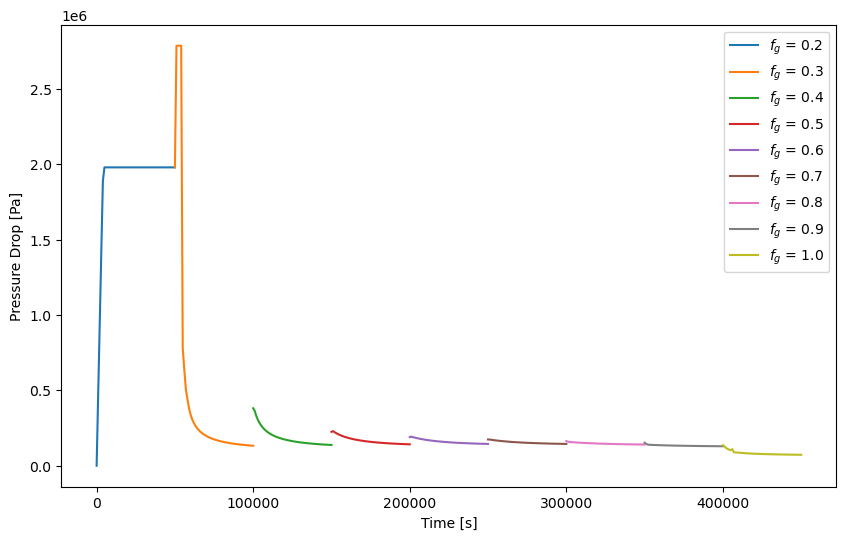

In [28]:
df_presss = []
for fgx in fgs:
    df_press = parse_openfoam_case(f'fg{int(fgx*100)}', variables=['p'], time_dirs=[str(i) for i in range(0, 50_001, 1_000)])
    df_press['p'] = df_press['p'].apply(lambda x: x[0] - x[-1])
    df_presss.append(df_press)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, df_press in enumerate(df_presss):
    time = np.arange(i*50_000, (i+1)*50_000 + 1, 1_000)
    ax.plot(time, df_press['p'], label=f'$f_g$ = {fgs[i]}')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Pressure Drop [Pa]')
ax.legend()
plt.show()

/tmp/ipykernel_1457193/2889927998.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_sa = pd.concat([df_sat.drop(['Sa', 'Sb'], axis=1), df_sat['Sa'].apply(pd.Series)], axis=1)


Text(0, 0.5, '$S_g$ [-]')

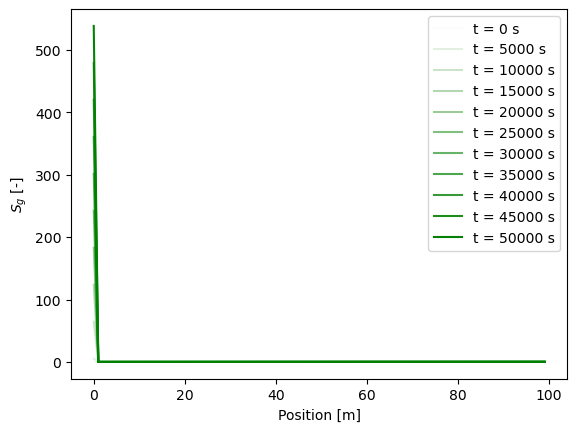

In [36]:
df_sat = parse_openfoam_case('fg30', variables=['Sa', 'Sb'], time_dirs=[str(i) for i in range(0, 50_001, 1_000)])

df_sa = pd.concat([df_sat.drop(['Sa', 'Sb'], axis=1), df_sat['Sa'].apply(pd.Series)], axis=1)

for i in np.linspace(0, len(df_sa)-1, 11, dtype=int):
    plt.plot(df_sa.columns, df_sa.iloc[i], color='green', alpha=(i+1)/(len(df_sa)+1), label=f't = {df_sa.index[i]} s')

plt.legend()
plt.xlabel('Position [m]')
plt.ylabel('$S_g$ [-]')